In [1]:
import numpy as np
import arviz as az
# import pymc3 as pm
import pickle
import time
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
from pp_mix.params_helper import make_default_strauss
import pp_mix.protos.py.params_pb2 as params_pb2


# from pp_mix.state import extract_chain
from pp_mix.interface import ConditionalMCMC, estimate_density_seq, simulate_strauss2d
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState, UnivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

# Execution times as dimension increases

In [ ]:
def generate_data(dim):
    if (dim == 1):
        data = np.concatenate([
            np.random.normal(loc = 5, size=100), 
            np.random.normal(loc = -5, size=100)
        ])
    else:
        data = np.vstack([
           [mvn.rvs(mean=np.ones(dim) * 5, cov=np.eye(dim)) for _ in range(100)],
           [mvn.rvs(mean=np.ones(dim) * (-5), cov=np.eye(dim)) for _ in range(100)]])
    return data

In [ ]:
nrep = 10
dimrange = [1, 2, 3, 4, 5]
strauss_times = np.zeros((nrep, len(dimrange)))

nrange = [5, 10, 20]
dpp_times = np.zeros((nrep, len(dimrange), len(nrange)))


for i in range(nrep):
    print("Running rep: {0}".format(i))
    for j, dim in enumerate([1, 2, 3, 4, 5]):
        data = generate_data(dim)
        if dim == 1:
            prec_params = params_pb2.GammaParams(alpha=1.0, beta=1.0)
        else:
            prec_params = params_pb2.WishartParams(
                nu=dim+1,identity=True, sigma=3, dim=dim)
        gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)


        strauss_params = make_default_strauss(data)
        strauss_params.fixed_params = False
        strauss_sampler = ConditionalMCMC(
            pp_params=strauss_params,
            prec_params=prec_params,
            jump_params=gamma_jump_params)

        start = time.time()
        strauss_sampler.run(0, 2, 5, data)
        strauss_times[i, j] = time.time() - start

            
        for k, n in enumerate(nrange):
            
            if n == 20 and dim > 3:
                continue
            
            if n == 10 and dim > 4:
                continue
                
            dpp_params = params_pb2.DPPParams(nu=2.0, rho=3.0, N=n)
            dpp_sampler = ConditionalMCMC(
                pp_params=dpp_params, 
                prec_params=prec_params,
                jump_params=gamma_jump_params)
            start = time.time()
            dpp_sampler.run(0, 2, 5, data)
            dpp_times[i, j, k] = time.time() - start

In [ ]:
# with open("data/execution_times.pickle", "wb") as fp:
#     pickle.dump({"dpp": dpp_times, "strauss": strauss_times}, fp)

In [ ]:
with open("data/execution_times.pickle", "rb") as fp:
    times = pickle.load(fp)
    
strauss_times = times["strauss"]
dpp_times = times["dpp"]

In [ ]:
nrange = [5, 10, 20]
dimrange = [1, 2, 3, 4, 5]

plt.plot(dimrange, np.median(strauss_times, axis=0), label="Strauss")
# for k, n in enumerate(nrange):

plt.plot(dimrange[:4], np.median(dpp_times[:, :4, 0], axis=0), label="DPP, N:{0}".format(nrange[0]))
plt.plot(dimrange[:4], np.median(dpp_times[:, :4, 1], axis=0),  label="DPP, N:{0}".format(nrange[1]))
# plt.plot(dimrange[:3], np.median(dpp_times[:, :3, 2], axis=0), label="dpp, N:{0}".format(dimrange[2]))

# plt.yscale("log")
plt.ylim(ymax=10)
plt.xticks(dimrange)
plt.legend()

plt.ylabel("execution times (s)", fontsize=15)
plt.savefig("images/exec_times.pdf")
plt.show()

In [ ]:
dpp_times[:, 0, 1] 

In [ ]:
with open("data/execution_times.pickle", "rb") as fp:
    tims_ = pickle.load(fp)
    
dpp_times = tims_["dpp"]
strauss_times = tims_["strauss"]

In [ ]:
np.mean(dpp_times[:, 1, 2] / strauss_times[:, 1])

In [ ]:
dim = 2
data = generate_data(dim)

prec_params = params_pb2.WishartParams(
                nu=dim+1,identity=True, sigma=3, dim=dim)
dpp_params = params_pb2.DPPParams(nu=2.0, rho=3.0, N=50)
dpp_sampler = ConditionalMCMC(
    pp_params=dpp_params, 
    prec_params=prec_params,
    jump_params=gamma_jump_params)
start = time.time()
dpp_sampler.run(0, 2, 5, data)
dpp_time = time.time() - start

In [ ]:
np.median(dpp_time / strauss_times[:, 1])

# Simulation

(array([ 22.,  62.,  23.,  33., 131.,  15.,  87.,  19.,  68.,  40.]),
 array([-5.62265426, -4.31200308, -3.0013519 , -1.69070072, -0.38004955,
         0.93060163,  2.24125281,  3.55190399,  4.86255517,  6.17320635,
         7.48385753]),
 <a list of 10 Patch objects>)

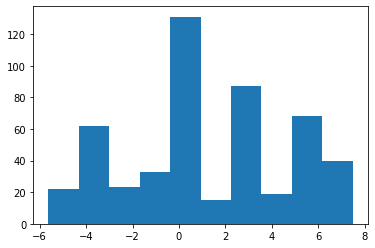

In [2]:
data = np.loadtxt("data/data_univ_miller_dunson.txt")
plt.hist(data)

In [3]:
prec_params = params_pb2.WishartParams(
                nu=dim+1,identity=True, sigma=3, dim=1)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)
dpp_params = params_pb2.DPPParams(nu=2.0, rho=3.0, N=50)
dpp_sampler = ConditionalMCMC(
    pp_params=dpp_params, 
    prec_params=prec_params,
    jump_params=gamma_jump_params)
dpp_sampler.run(50000, 50000, 5, data)

NameError: name 'dim' is not defined

In [ ]:
# strauss_params = make_default_strauss(data)

# strauss_params.init.gamma = np.exp(-30)
# # strauss_params.init.beta = 0.0000001
# strauss_params.fixed_params = True
# strauss_params.init.R = 5

# strauss_sampler = ConditionalMCMC(
#     pp_params=strauss_params,
#     prec_params=prec_params,
#     jump_params=gamma_jump_params)

# strauss_sampler.run(50000, 50000, 5, data)

In [ ]:
dpp_chains = loadChains("data/dpp_univ_cond.recordio", UnivariateMixtureState)
strauss_chains = loadChains("data/perturb_strauss_chains.recordio", UnivariateMixtureState)

In [ ]:
from scipy.stats import dirichlet

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5])
w_t = np.array([0.25, 0.25, 0.3, 0.2])

alpha0 = 500
L = 10000
y_t = np.random.choice(len(w_t), size=L, replace=True, p=w_t)
locations = true_mu[y_t] + true_sigma[y_t] * np.random.normal(size=L)
weights = dirichlet.rvs(np.ones(L) * 500 / L)[0, :]
s = 0.25


def f0(x):
    out = np.zeros_like(x)
    for w, l in zip(weights, locations):
        out += w * norm.pdf(x, l, s)
    return out

In [ ]:
xgrid = np.linspace(-6, 8, 500)
f_eval = f0(xgrid)

dens_dpp = estimate_density_seq(dpp_chains, xgrid)
plt.plot(xgrid, np.mean(dens_dpp, axis=0), color="orange", label="DPP")

dens_strauss = estimate_density_seq(strauss_chains, xgrid)
plt.plot(xgrid, np.mean(dens_strauss, axis=0), color="steelblue", label="Strauss")

plt.plot(xgrid, f_eval, label="True", color="red")
plt.legend()

plt.savefig("images/dpp_vs_strauss_dens.pdf")
plt.show()

In [ ]:
dpp_ma_chain = np.array([max(x.clus_alloc) + 1 for x in dpp_chains])
strauss_ma_chain = np.array([max(x.clus_alloc) + 1 for x in strauss_chains])

bars = np.arange(1, 10)
heights = np.array([np.sum(strauss_ma_chain == i) for i in bars]) / len(strauss_ma_chain)
# plt.bar(bars - width/2, heights / len(strauss_ma_chain), width=width,
#         edgecolor="white", label="strauss")
plt.plot(bars, heights, 'D--', label="Strauss", linewidth=2)


heights = np.array([np.sum(dpp_ma_chain == i) for i in bars]) / len(dpp_chains)
plt.plot(bars, heights, '*:', label="DPP", linewidth=2)

plt.legend()
plt.xticks(bars)
plt.axhline(y=0, color='k', alpha=0.5)
plt.xlim(0, 10)
plt.savefig("images/dpp_vs_strauss_k.pdf")
plt.show()

In [ ]:
strauss_sampler.serialize_chains("data/perturb_strauss_chains.recordio")